# Data Cleaning

## Outline
0. Load and join dataframes
1. Handle missing values
   - Identify columns with missing data
   - Decide on appropriate strategies for each column
   - Impute or handle missing values as needed
2. Convert data types
   - Change 'start_date' to datetime format
   - Convert 'home_line_scores' and 'away_line_scores' to usable format
3. Handle outliers
   - Check for and address unrealistic values in numerical columns
4. Create derived features
   - Calculate point difference
   - Generate 'winner' column
   - Create time-based features from 'start_date'
5. Review and validate cleaned dataset

## Load Packages & Data

In [79]:
%load_ext autoreload
%autoreload 2

import sys
import os

# Add the project root to the Python path
notebook_dir = os.path.dirname(os.path.abspath('__file__'))
project_root = os.path.dirname(notebook_dir)
sys.path.append(project_root)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.data.cleaning import (
    merge_and_clean_dataframes,
    clean_dataframe,
    generate_and_save_team_pairs
)
from src.visualization.distribution_plots import (
    analyze_distribution,
    visualize_null_values,
    plot_mean_over_time,
    plot_null_frequency_by_season,
    plot_zero_values_by_year
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [91]:
# Load the games data from the parquet file
games_df = pd.read_parquet('../data/01_raw/games.parquet')

# Load the advanced team game stats from the parquet file
advanced_stats_df = pd.read_parquet('../data/01_raw/advanced_team_game_stats.parquet')

# Load the team game stats from the parquet file
team_stats_df = pd.read_parquet('../data/01_raw/team_game_stats.parquet')

# Load the team talent data from the parquet file
team_talent_df = pd.read_parquet('../data/01_raw/team_talent.parquet')

In [59]:
def print_df_columns(df_name, df):
    print(f"\nColumns in {df_name}:")
    for col in df.columns:
        print(f"- {col}")
    print()

# Print columns for each DataFrame
print_df_columns("games_df", games_df)
print_df_columns("advanced_stats_df", advanced_stats_df)
print_df_columns("team_stats_df", team_stats_df)
print_df_columns("team_talent_df", team_talent_df)
print_df_columns("merged_df", df)


Columns in games_df:
- id
- season
- week
- season_type
- start_date
- start_time_tbd
- completed
- neutral_site
- conference_game
- attendance
- venue_id
- venue
- home_id
- home_team
- home_conference
- home_division
- home_points
- home_line_scores
- home_post_win_prob
- home_pregame_elo
- home_postgame_elo
- away_id
- away_team
- away_conference
- away_division
- away_points
- away_line_scores
- away_post_win_prob
- away_pregame_elo
- away_postgame_elo
- excitement_index
- highlights
- notes


Columns in advanced_stats_df:
- game_id
- season
- week
- team
- opponent
- offense
- defense


Columns in team_stats_df:
- id
- team_id
- team_name
- team_conference
- home_away
- points
- fumblesRecovered
- rushingTDs
- puntReturnYards
- puntReturnTDs
- puntReturns
- passingTDs
- kickingPoints
- firstDowns
- thirdDownEff
- fourthDownEff
- totalYards
- netPassingYards
- completionAttempts
- yardsPerPass
- rushingYards
- rushingAttempts
- yardsPerRushAttempt
- totalPenaltiesYards
- turnovers

## Null team_stats_df

In [92]:
# Filter games_df to include only rows where the id exists in team_stats_df
initial_count = len(games_df)
games_df = games_df[games_df['id'].isin(team_stats_df['id'])]
filtered_count = len(games_df)

# Calculate the number and percentage of rows dropped
rows_dropped = initial_count - filtered_count
percentage_dropped = (rows_dropped / initial_count) * 100

print(f"Rows dropped: {rows_dropped}")
print(f"Percentage of rows dropped: {percentage_dropped:.2f}%")

Rows dropped: 1569
Percentage of rows dropped: 15.14%


## Drop Duplicates

In [93]:
# Function to drop duplicates and report
def drop_duplicates_and_report(df, df_name):
    initial_rows = len(df)
    # Convert numpy arrays to tuples before dropping duplicates
    df = df.applymap(lambda x: tuple(x) if isinstance(x, np.ndarray) else x)
    df = df.drop_duplicates()
    rows_dropped = initial_rows - len(df)
    print(f"{df_name}: Dropped {rows_dropped} duplicate rows")
    return df

# Drop duplicates from each dataframe
total_rows_dropped = 0
for df_name, df in [("games_df", games_df), ("advanced_stats_df", advanced_stats_df), 
                    ("team_stats_df", team_stats_df), ("team_talent_df", team_talent_df)]:
    try:
        initial_rows = len(df)
        df = drop_duplicates_and_report(df, df_name)
        rows_dropped = initial_rows - len(df)
        total_rows_dropped += rows_dropped
        # Update the original dataframe
        globals()[df_name] = df
    except TypeError as e:
        print(f"Error in {df_name}: {str(e)}")
        print("Columns causing issues:")
        for col in df.columns:
            try:
                df[col].duplicated()
            except TypeError:
                print(f"- {df_name}.{col}: {df[col].dtype}")

print(f"\nTotal duplicate rows dropped across all dataframes: {total_rows_dropped}")

/var/folders/yq/dnnn56yn2l34mgnc3mc_8kyr0000gn/T/ipykernel_57662/2020037444.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: tuple(x) if isinstance(x, np.ndarray) else x)


games_df: Dropped 439 duplicate rows
Error in advanced_stats_df: unhashable type: 'dict'
Columns causing issues:
team_stats_df: Dropped 878 duplicate rows
team_talent_df: Dropped 3 duplicate rows

Total duplicate rows dropped across all dataframes: 1320


## Join Data

In [94]:
# Use the function to merge and clean the dataframes
merged_df_final = merge_and_clean_dataframes(games_df, team_stats_df, advanced_stats_df, team_talent_df)

# Check the shape of the final dataframe
print("Shape of merged_df_final:", merged_df_final.shape)

df = merged_df_final.copy()

Shape of merged_df_final: (16708, 122)


## Check for Duplicates

In [95]:
# Check for duplicate 'id' and 'team' combinations
duplicate_id_team = df.duplicated(subset=['id', 'team'])
num_duplicates = duplicate_id_team.sum()
total_rows = len(df)
duplicate_percentage = (num_duplicates / total_rows) * 100

print(f"Number of duplicate 'id' and 'team' combinations: {num_duplicates}")
print(f"Percentage of duplicate 'id' and 'team' combinations: {duplicate_percentage:.2f}%")

# If you want to see the duplicate rows, uncomment the following line:
# print(df[duplicate_id_team])


Number of duplicate 'id' and 'team' combinations: 0
Percentage of duplicate 'id' and 'team' combinations: 0.00%


## Handle Missing Values

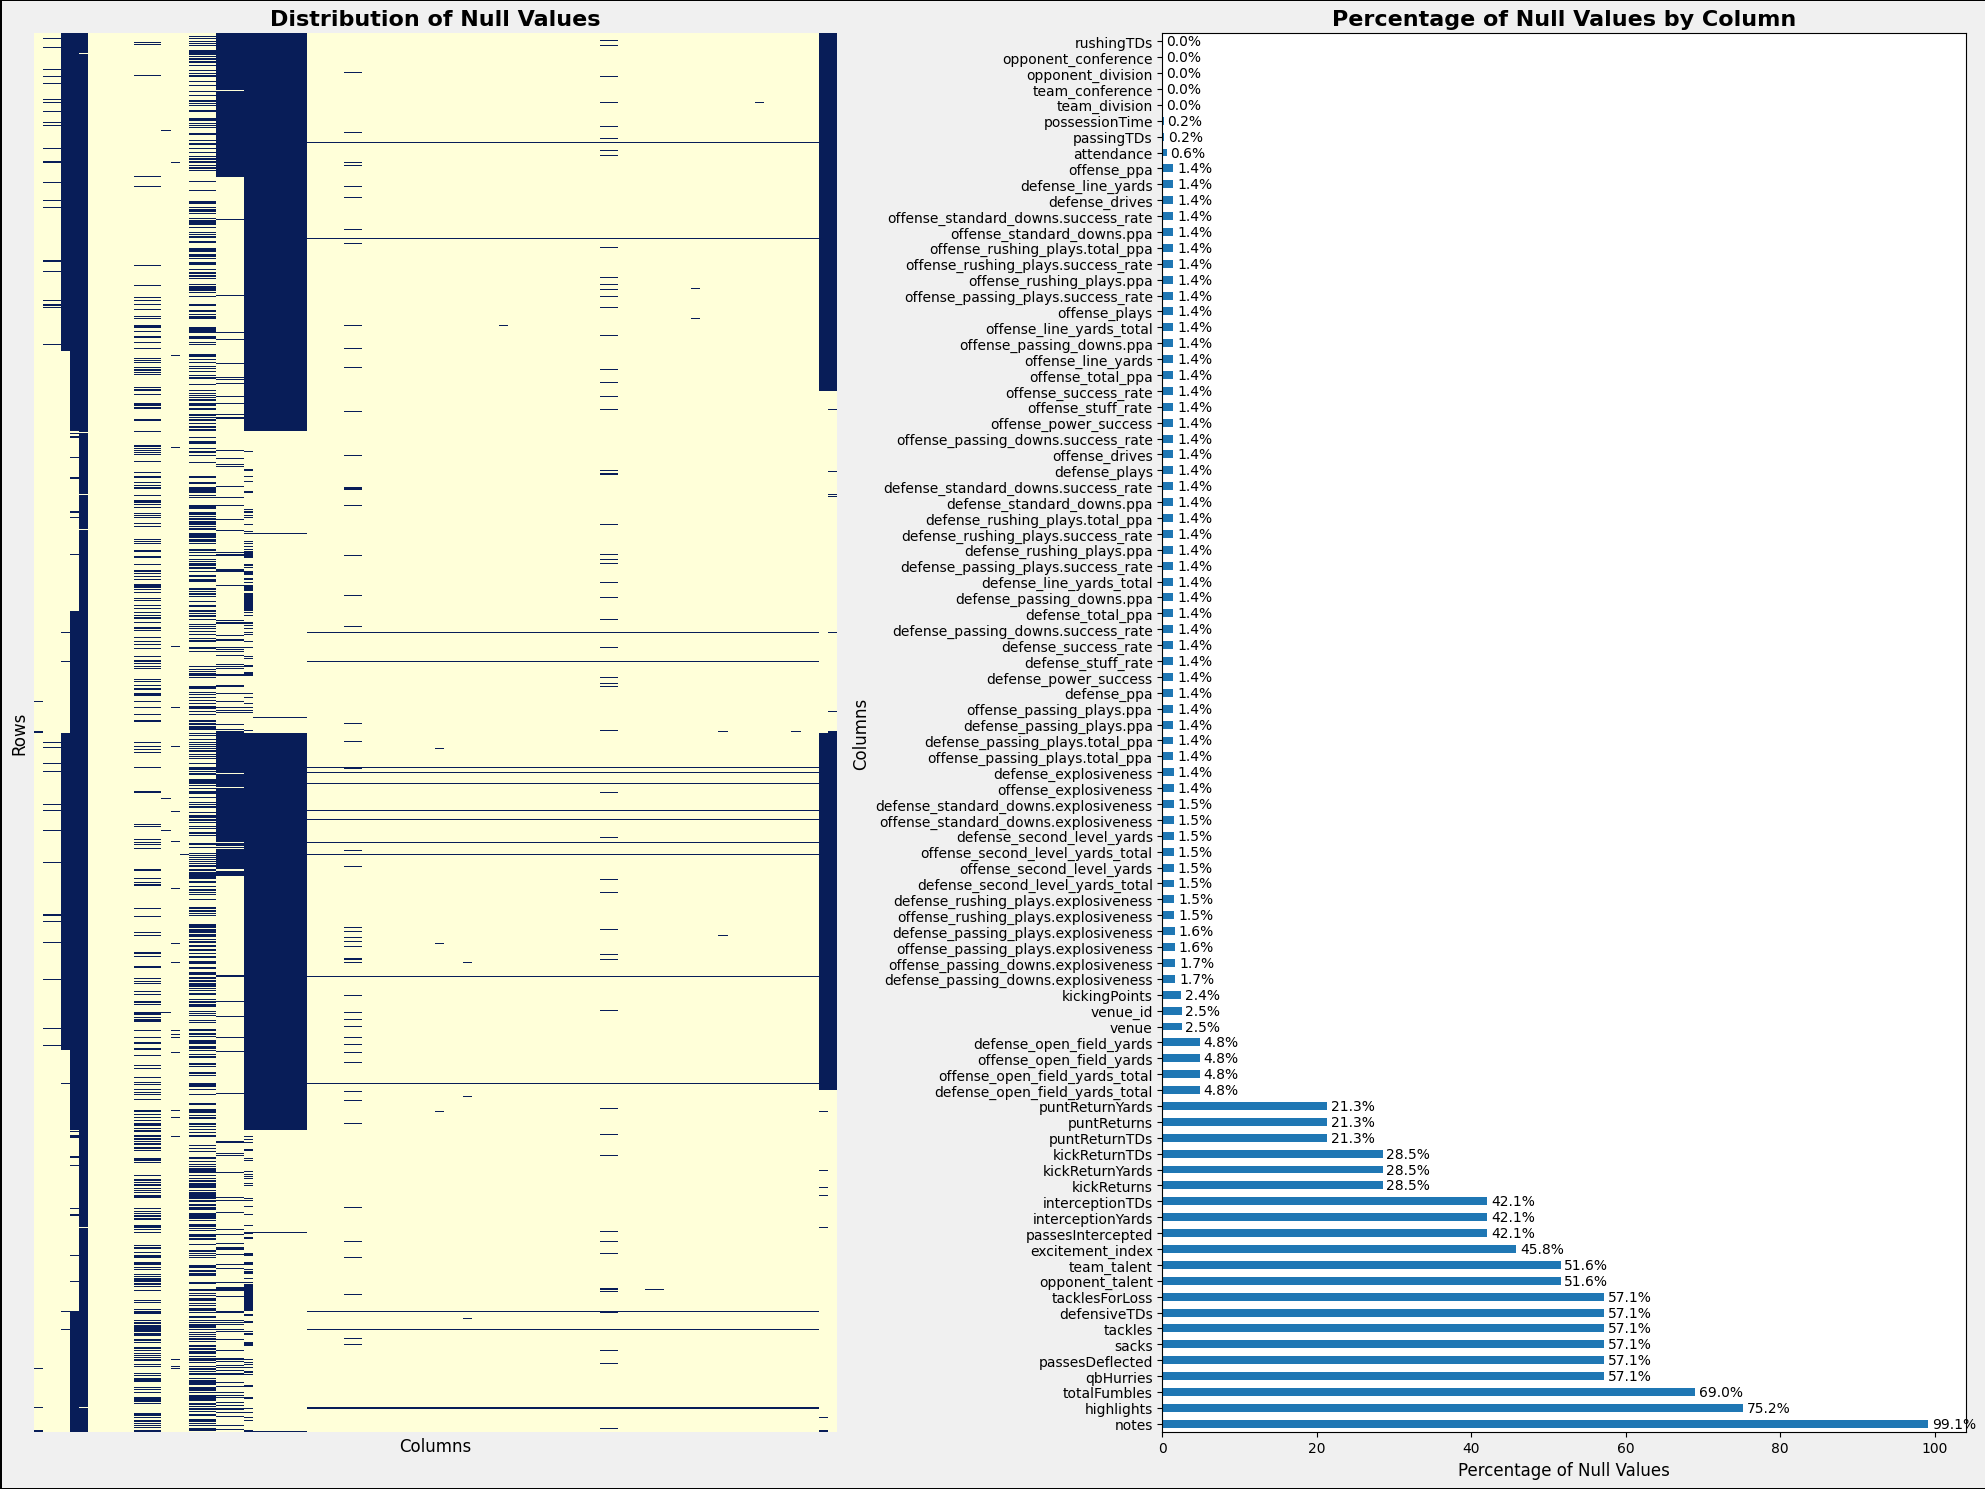

Columns with null values (sorted by percentage, descending):
notes: 16562 null values (99.13%)
highlights: 12570 null values (75.23%)
totalFumbles: 11521 null values (68.95%)
qbHurries: 9546 null values (57.13%)
passesDeflected: 9546 null values (57.13%)
sacks: 9546 null values (57.13%)
tackles: 9546 null values (57.13%)
defensiveTDs: 9546 null values (57.13%)
tacklesForLoss: 9546 null values (57.13%)
opponent_talent: 8614 null values (51.56%)
team_talent: 8614 null values (51.56%)
excitement_index: 7654 null values (45.81%)
passesIntercepted: 7029 null values (42.07%)
interceptionYards: 7029 null values (42.07%)
interceptionTDs: 7029 null values (42.07%)
kickReturns: 4763 null values (28.51%)
kickReturnYards: 4763 null values (28.51%)
kickReturnTDs: 4763 null values (28.51%)
puntReturnTDs: 3557 null values (21.29%)
puntReturns: 3557 null values (21.29%)
puntReturnYards: 3557 null values (21.29%)
defense_open_field_yards_total: 808 null values (4.84%)
offense_open_field_yards_total: 80

In [85]:
visualize_null_values(df)

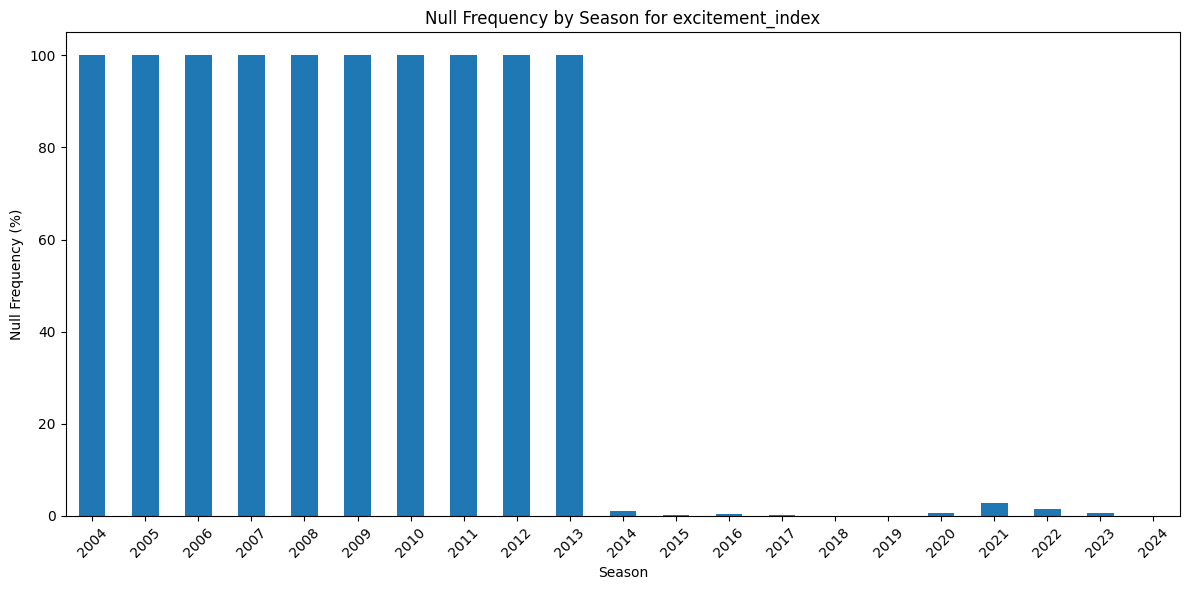

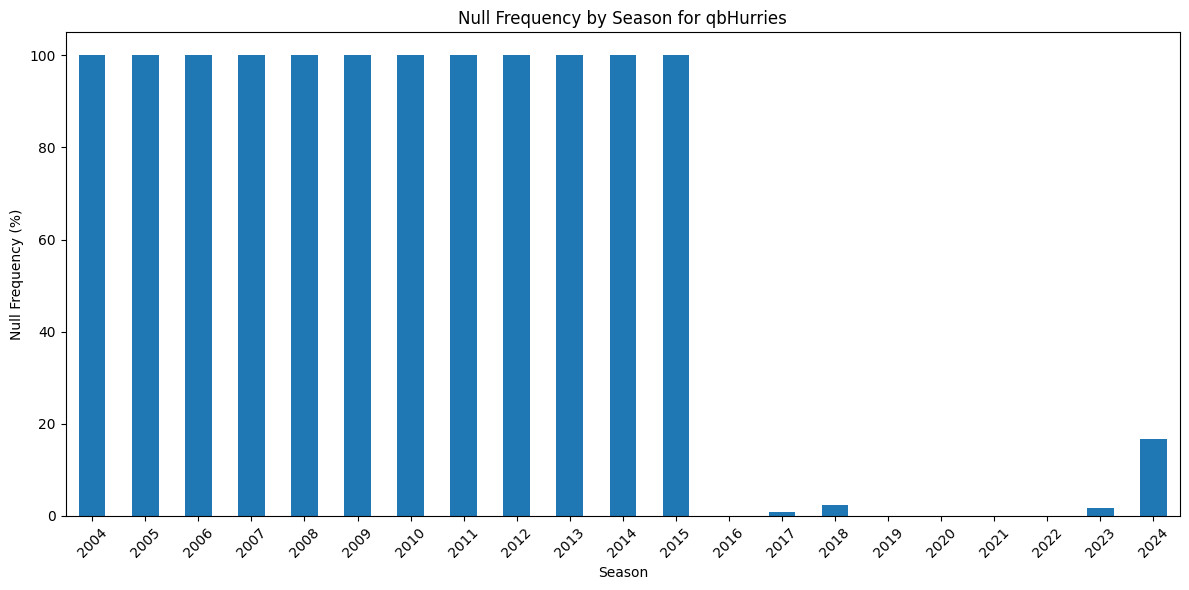

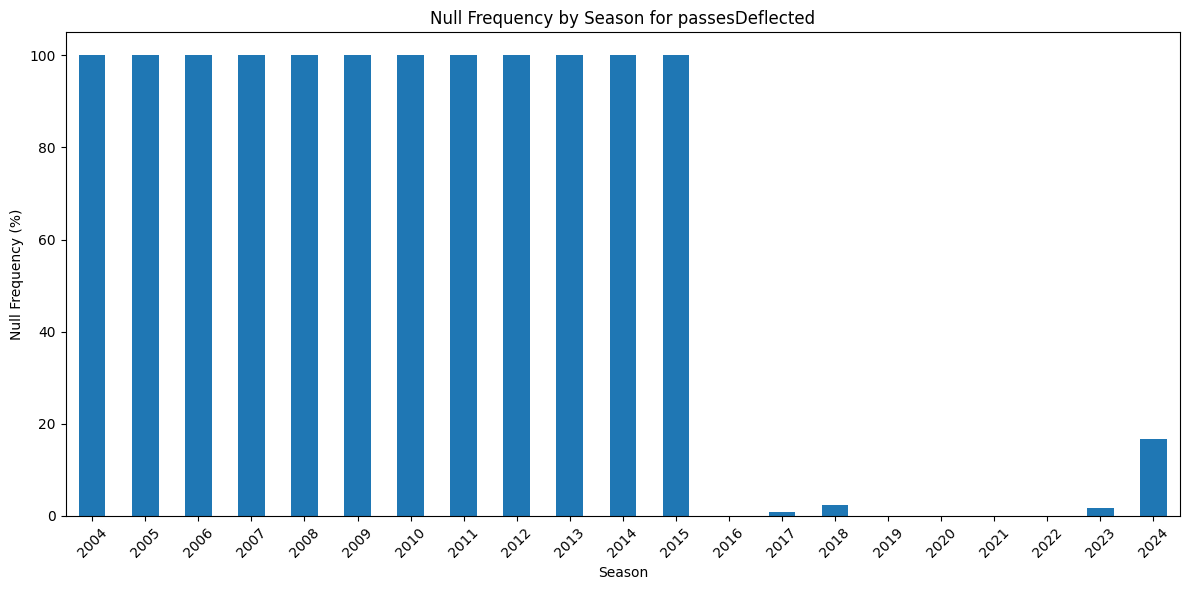

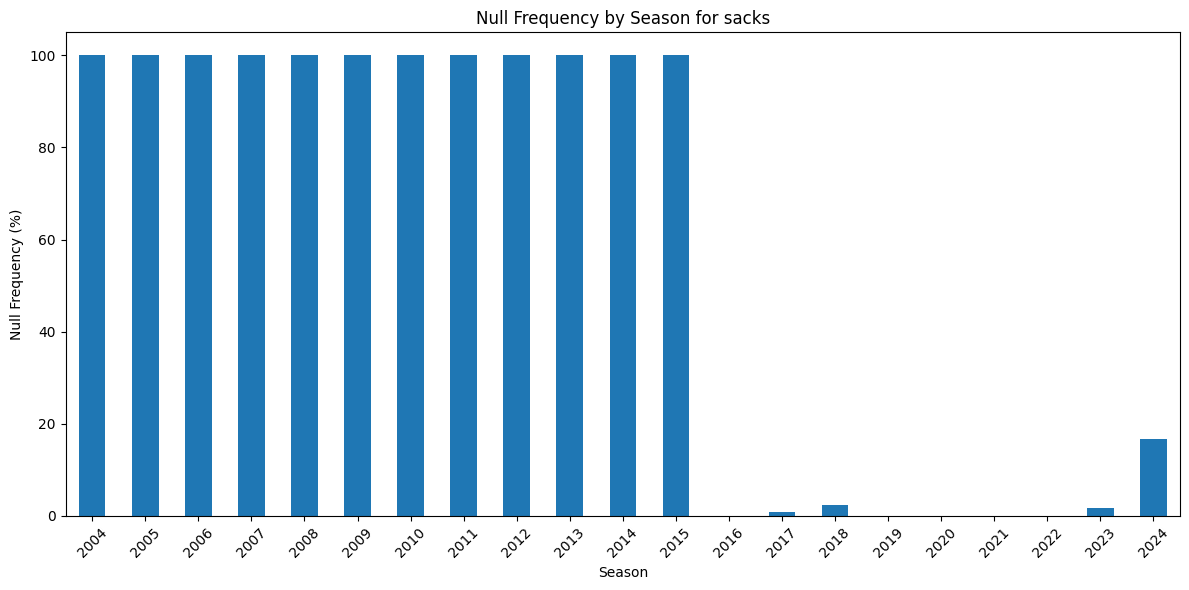

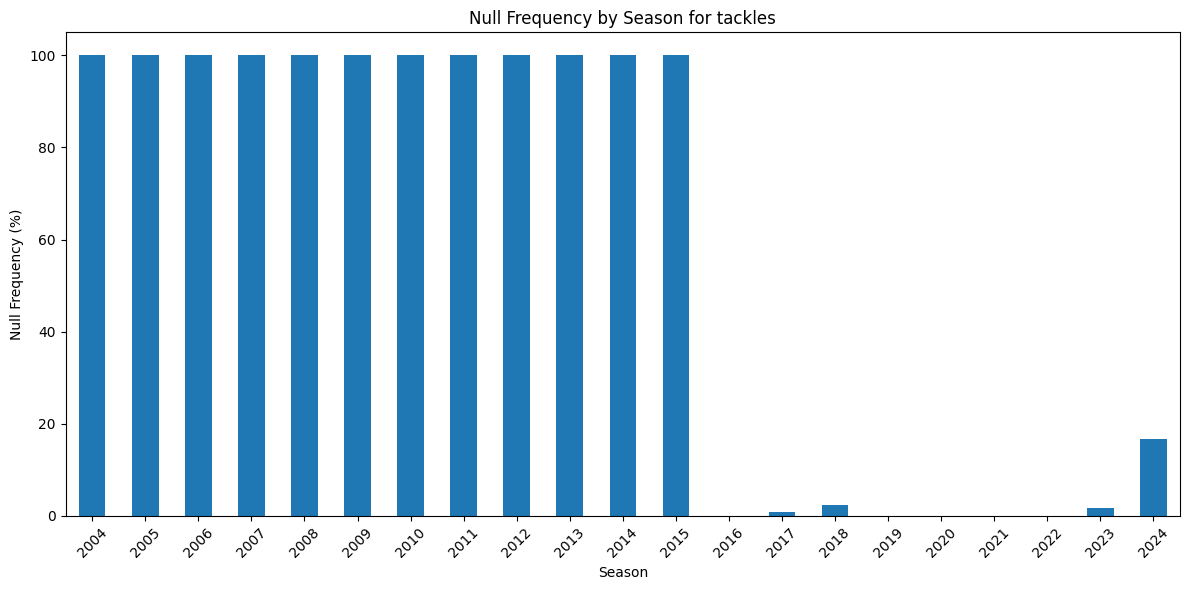

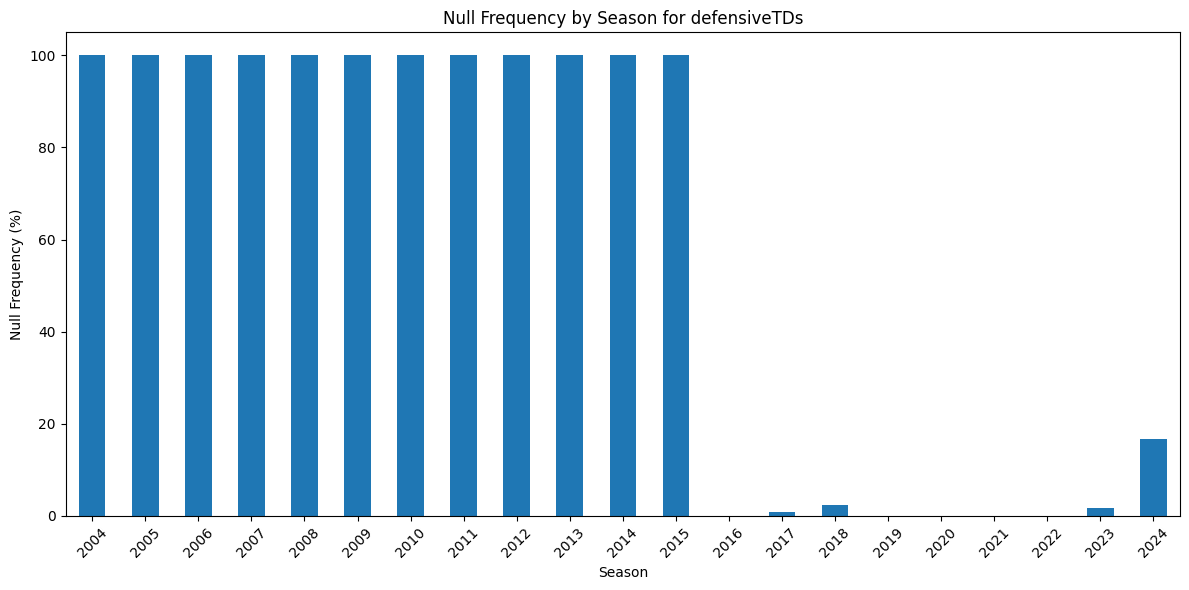

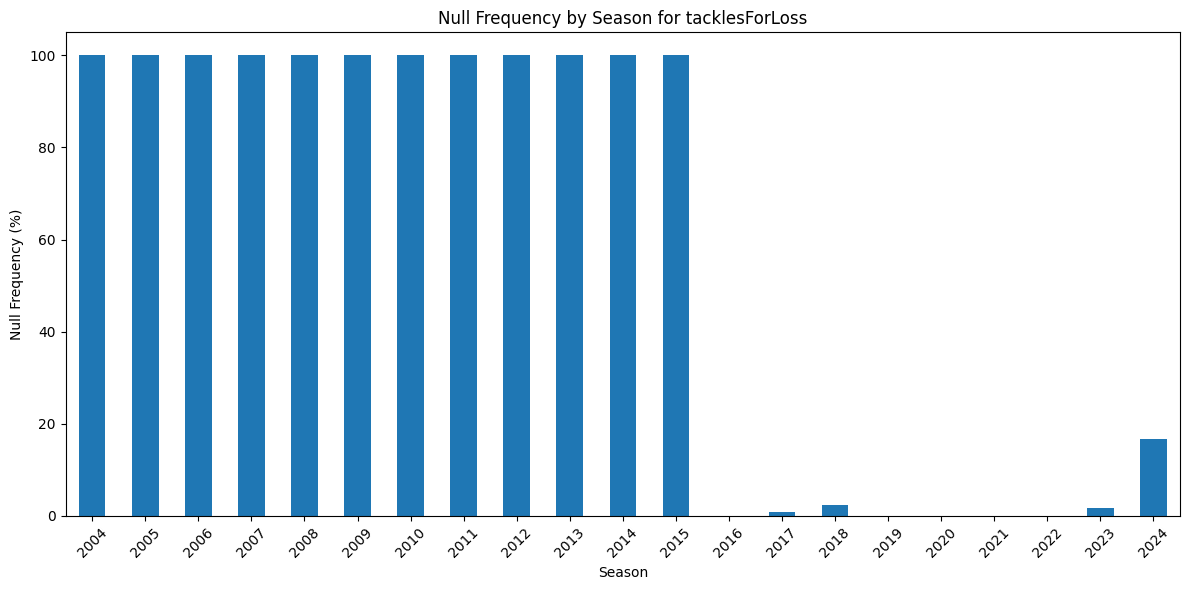

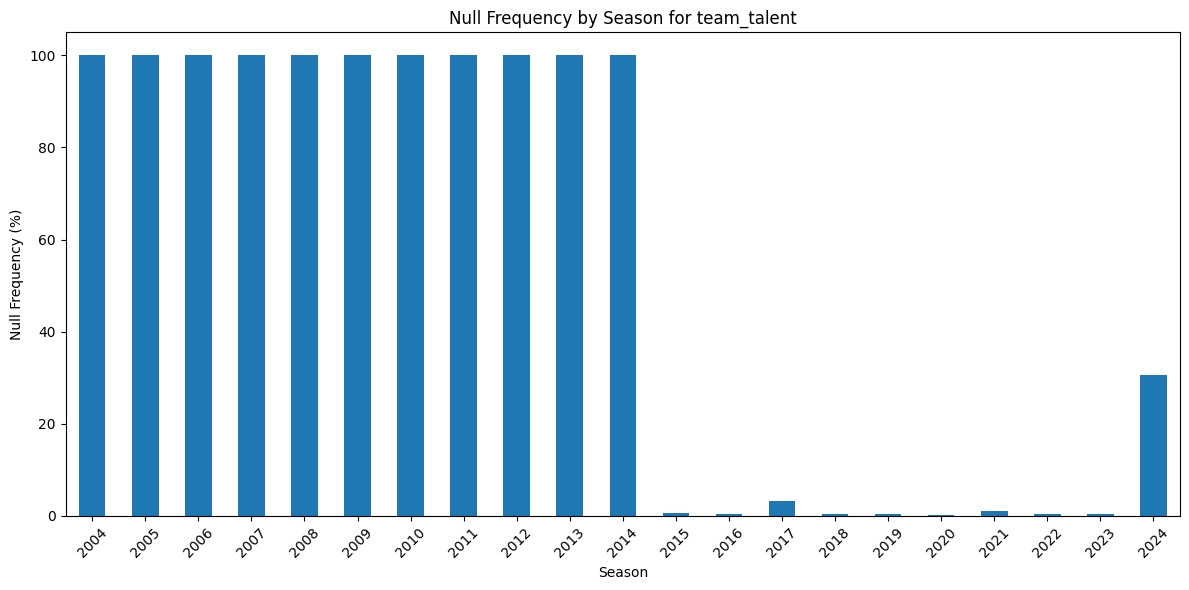

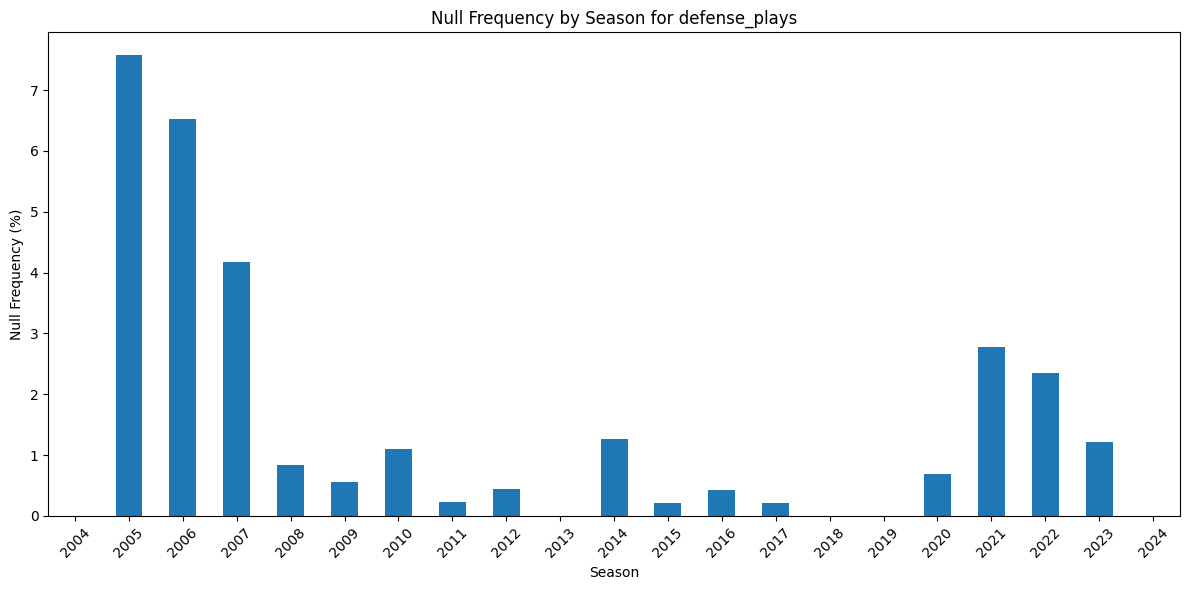

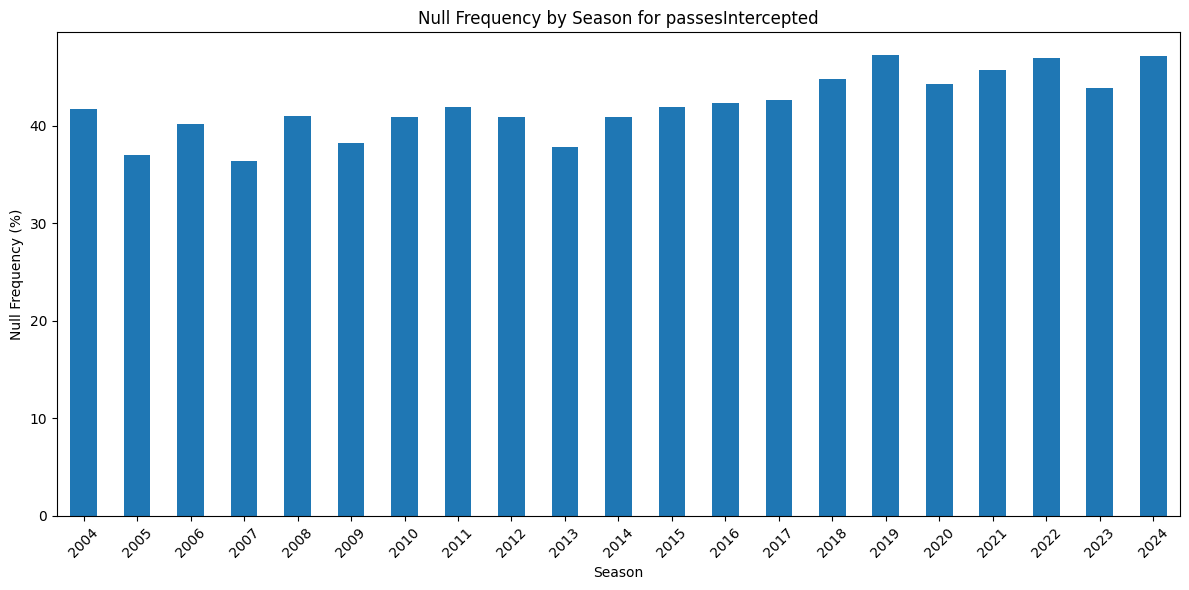

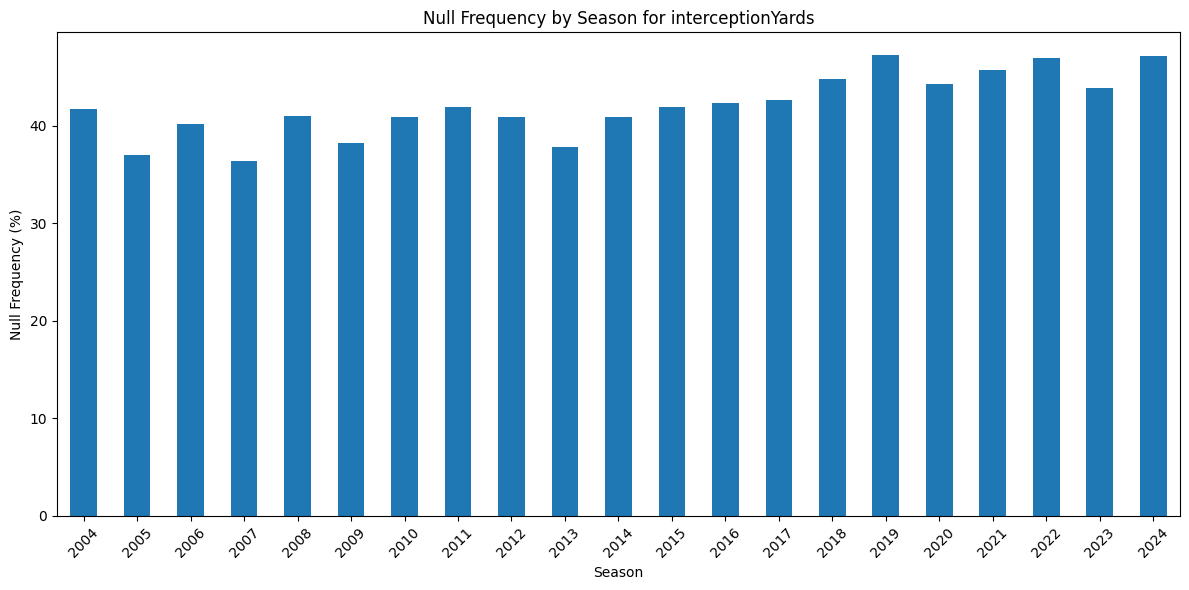

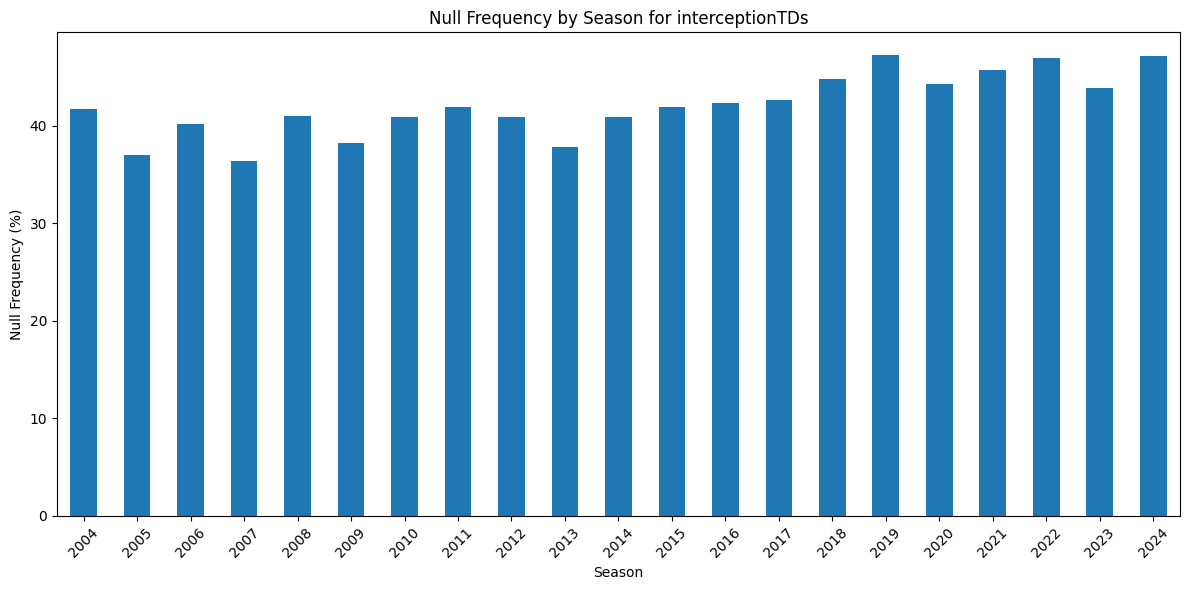

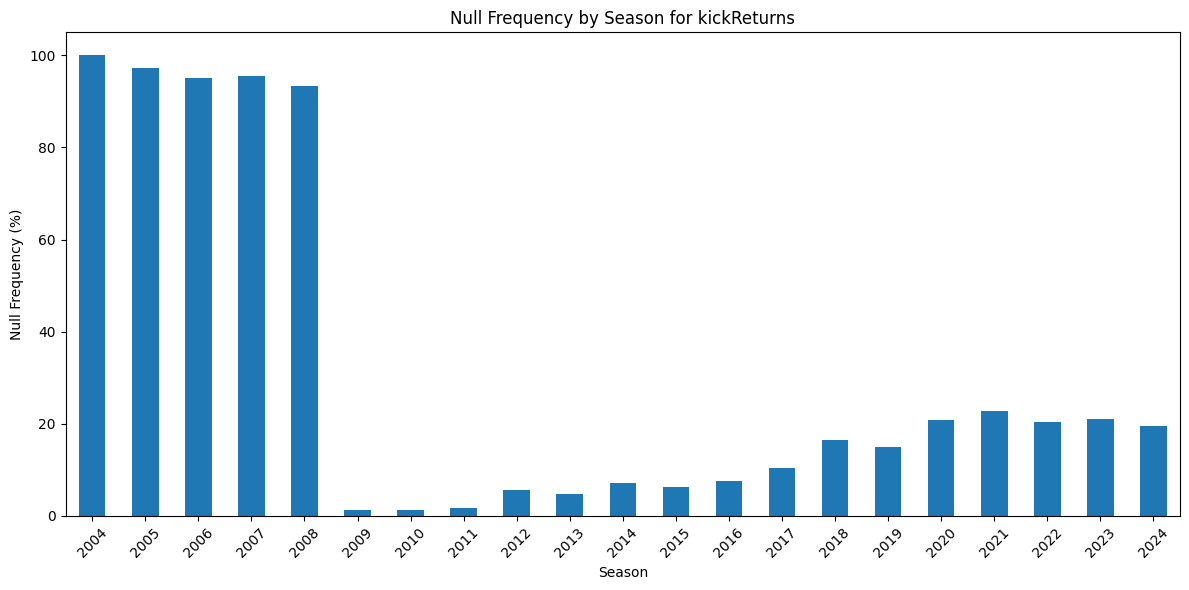

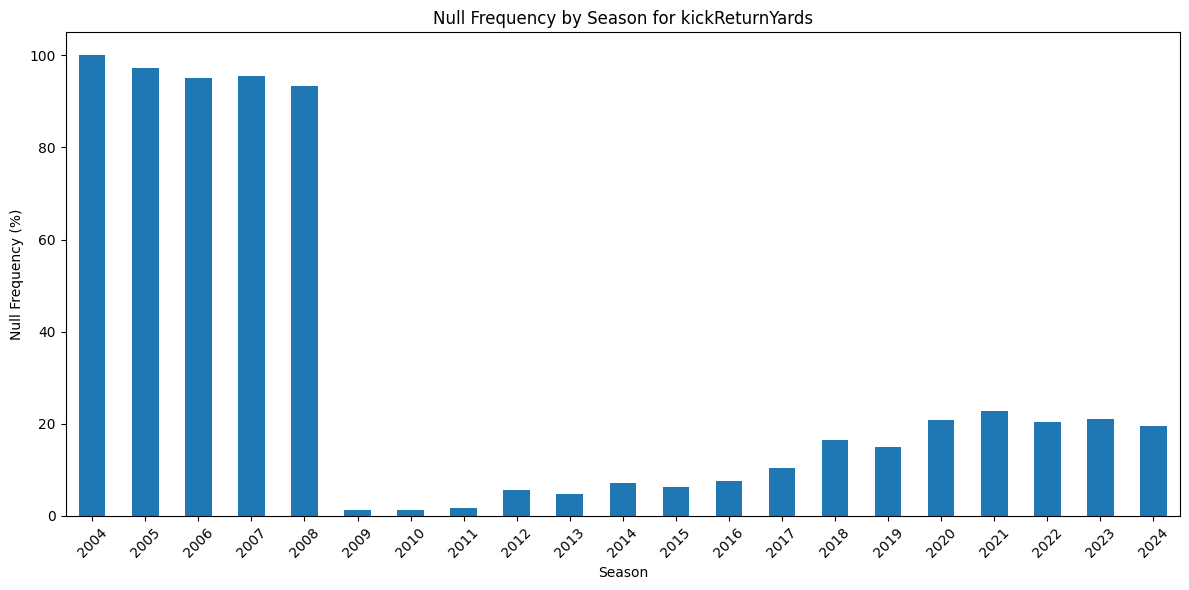

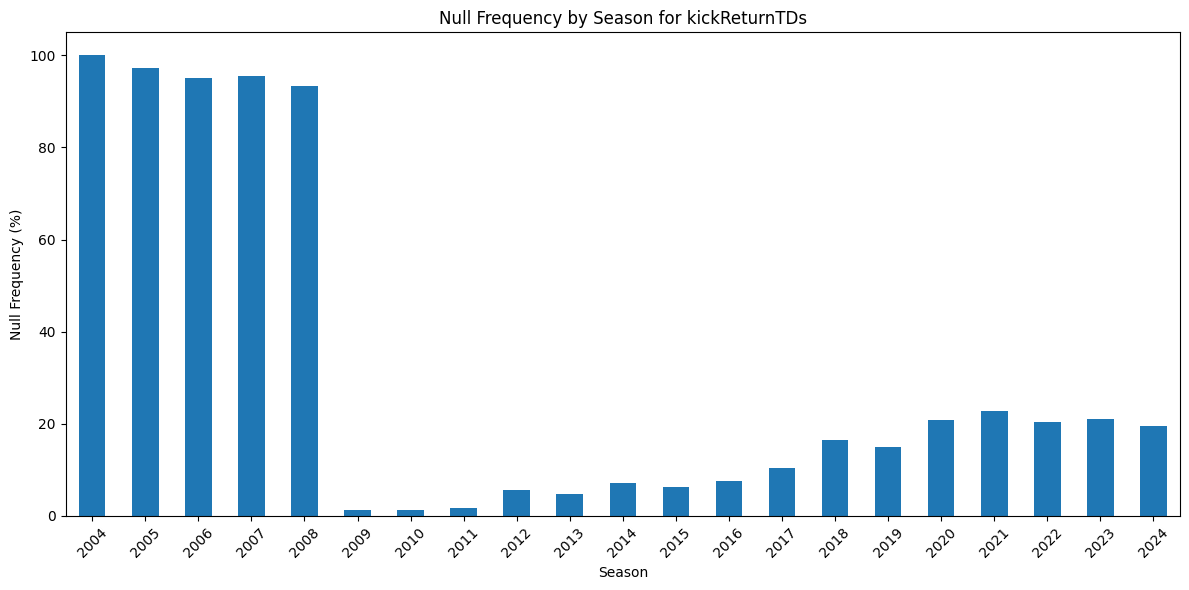

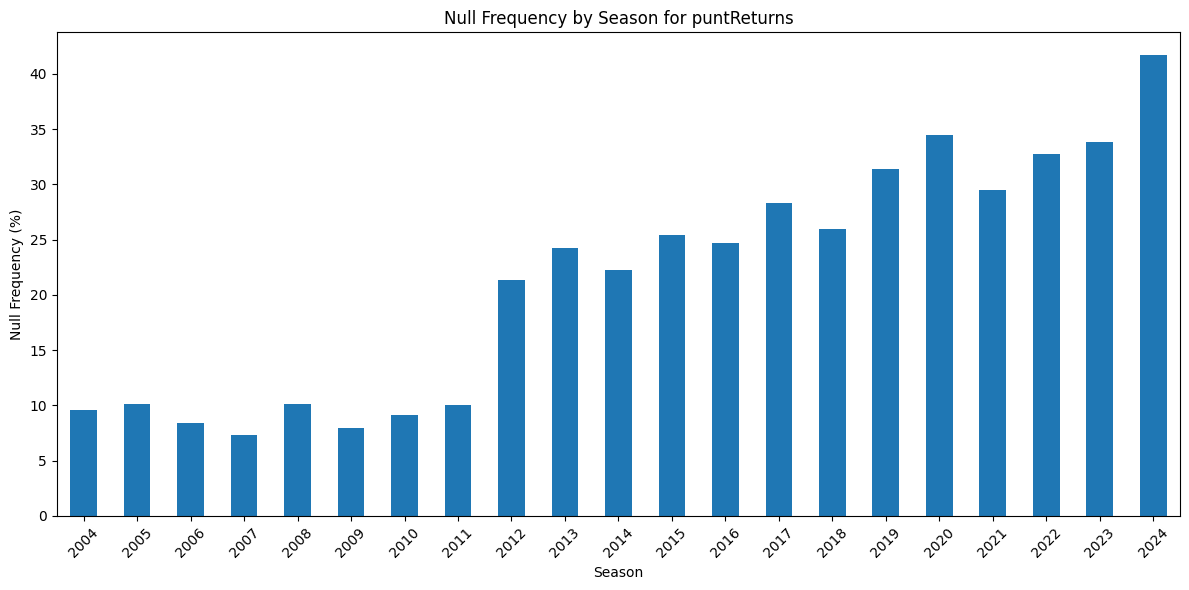

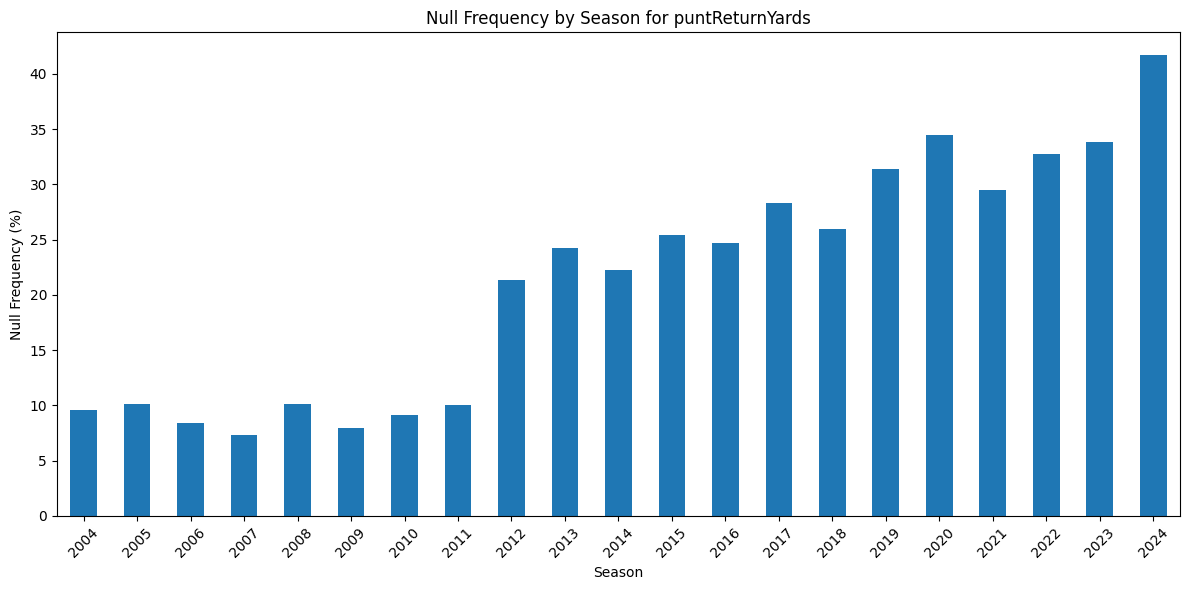

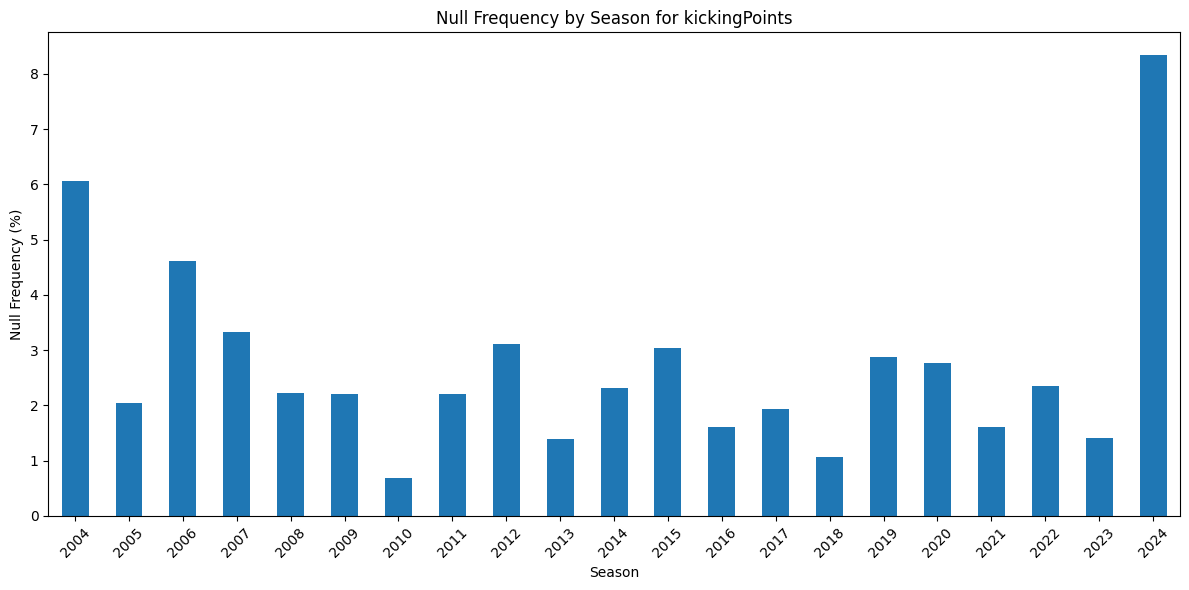

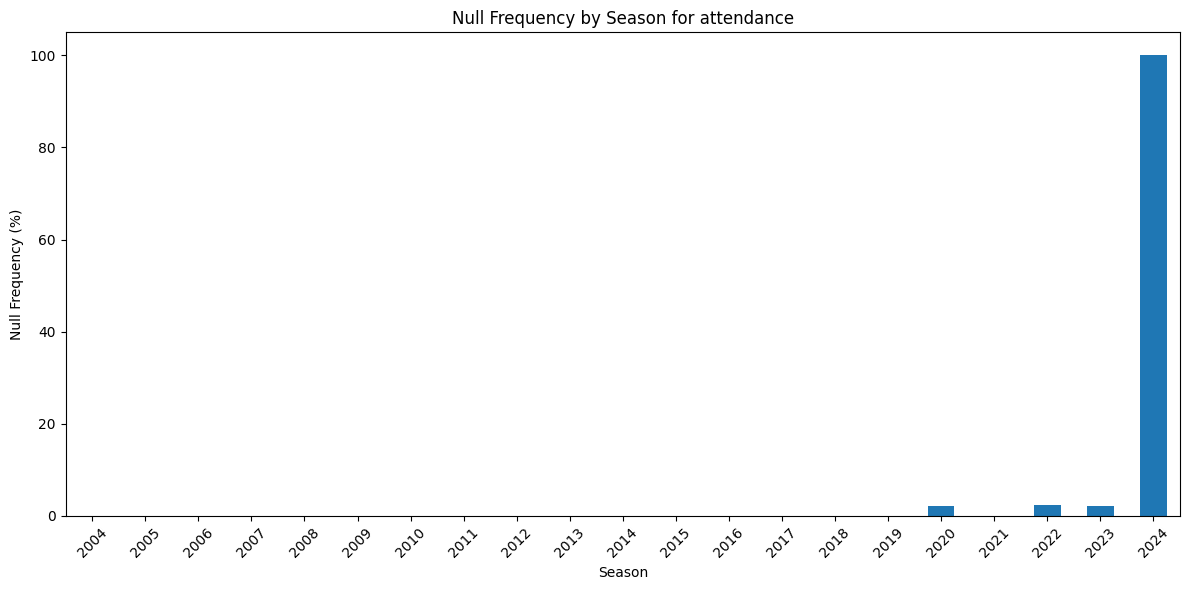

In [90]:
plot_null_frequency_by_season(df, [
    'excitement_index',
    'qbHurries',
    'passesDeflected',
    'sacks',
    'tackles',
    'defensiveTDs',
    'tacklesForLoss',
    'team_talent',
    'defense_plays',
    'passesIntercepted',
    'interceptionYards',
    'interceptionTDs',
    'kickReturns',
    'kickReturnYards',
    'kickReturnTDs',
    'puntReturns',
    'puntReturnYards',
    'kickingPoints',
    'attendance'
])

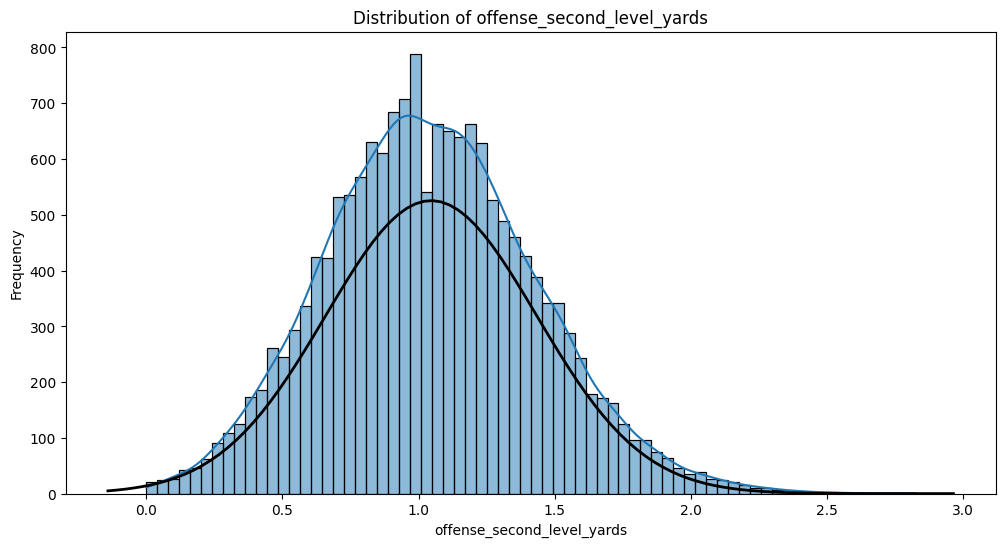

Shapiro-Wilk test - statistic: 0.9968, p-value: 0.0000
Skewness: 0.2293
Kurtosis: 0.0812


/Users/colingaffney/repos/personal-projects/college_football_predictor/venv/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 16459.
  res = hypotest_fun_out(*samples, **kwds)


In [62]:
analyze_distribution(df, 'offense_second_level_yards')

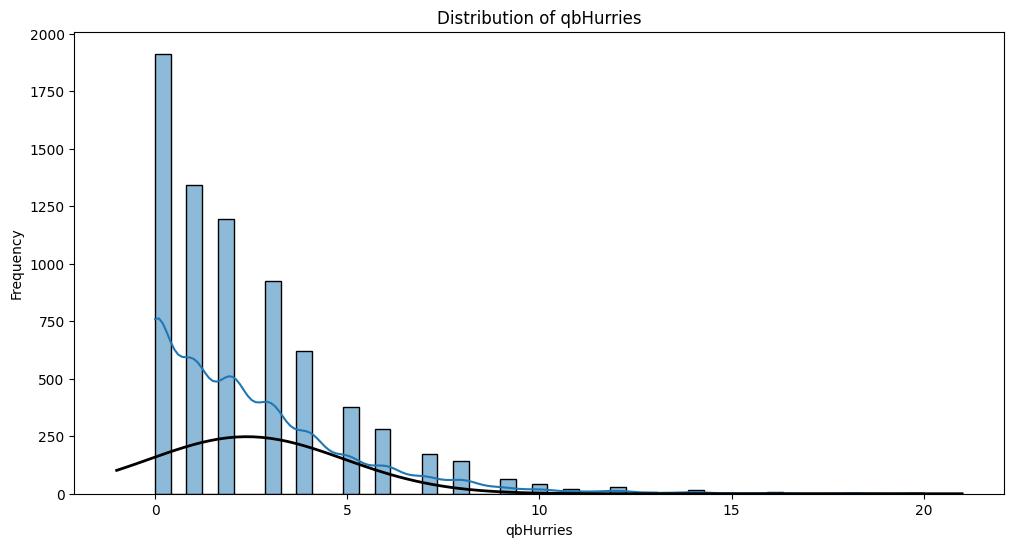

Shapiro-Wilk test - statistic: 0.8317, p-value: 0.0000
Skewness: 1.6959
Kurtosis: 4.3137


/Users/colingaffney/repos/personal-projects/college_football_predictor/venv/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 7162.
  res = hypotest_fun_out(*samples, **kwds)


In [58]:
analyze_distribution(df, 'qbHurries')

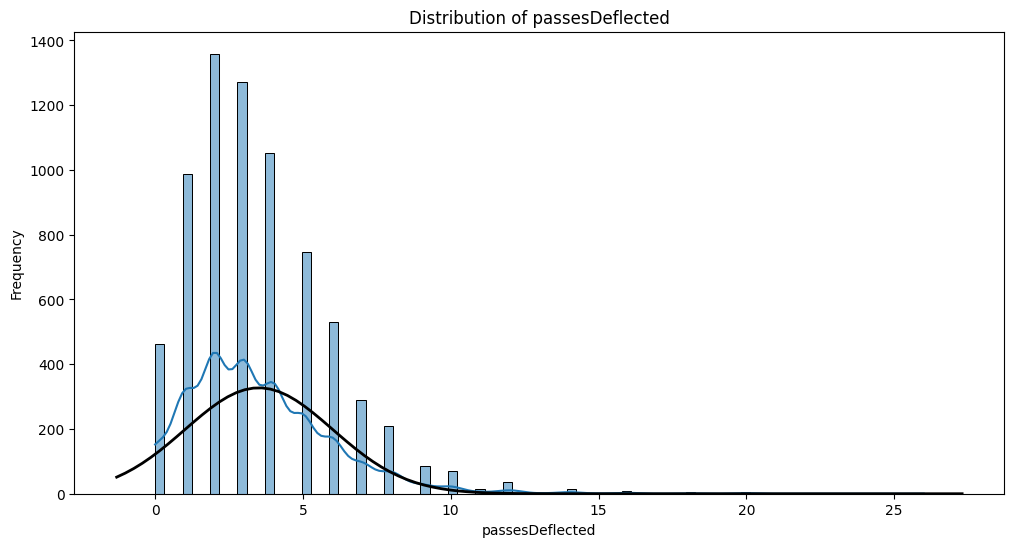

Shapiro-Wilk test - statistic: 0.8956, p-value: 0.0000
Skewness: 1.5235
Kurtosis: 5.4060


/Users/colingaffney/repos/personal-projects/college_football_predictor/venv/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 7162.
  res = hypotest_fun_out(*samples, **kwds)


In [57]:
analyze_distribution(df, 'passesDeflected')

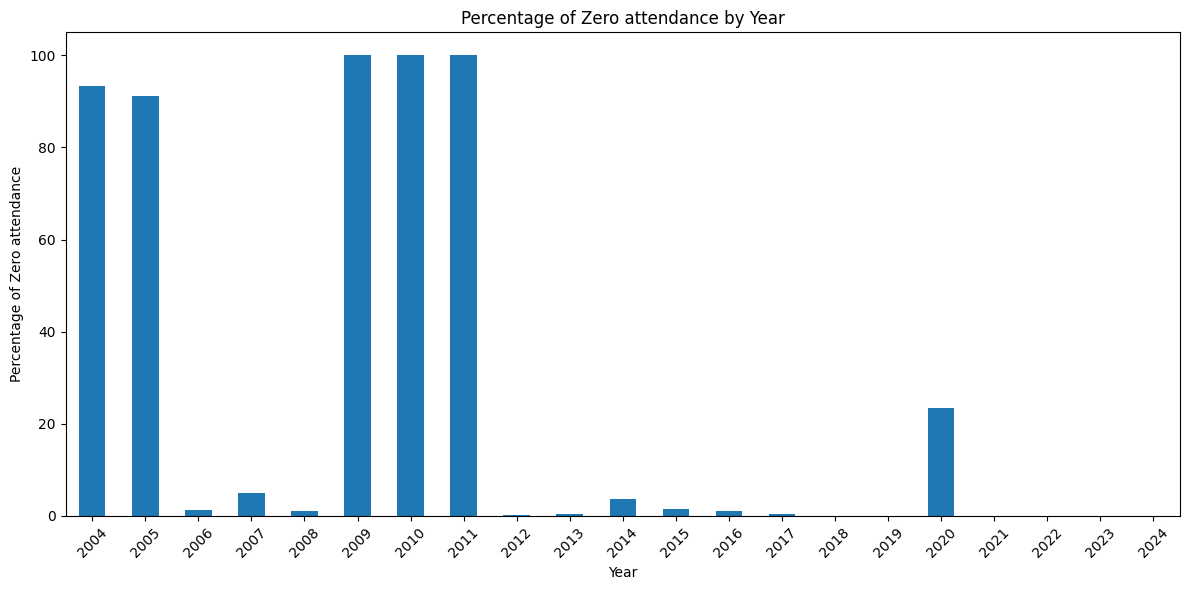

In [96]:
plot_zero_values_by_year(df, 'attendance')

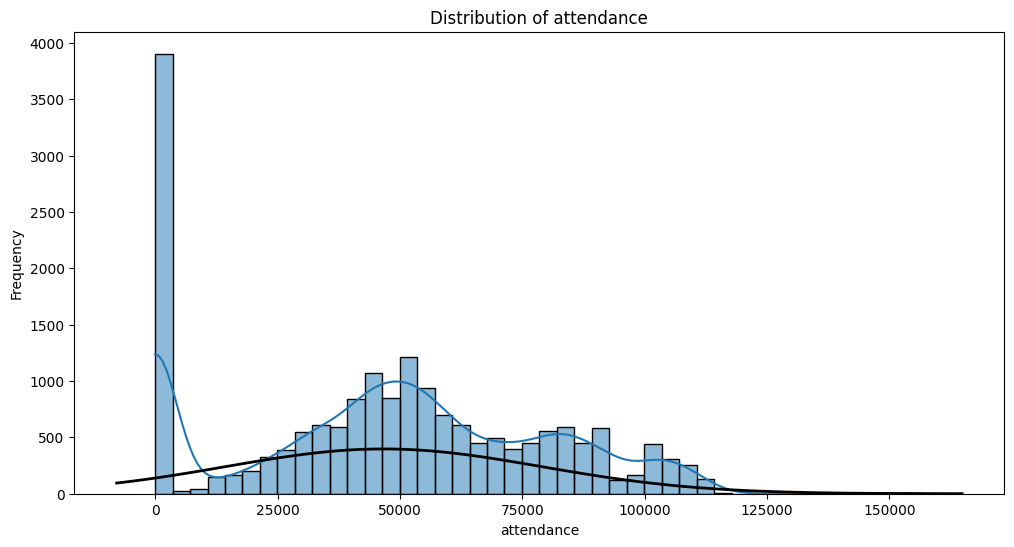

Shapiro-Wilk test - statistic: 0.9423, p-value: 0.0000
Skewness: 0.0227
Kurtosis: -0.9192


/Users/colingaffney/repos/personal-projects/college_football_predictor/venv/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 18564.
  res = hypotest_fun_out(*samples, **kwds)


In [30]:
analyze_distribution(df, 'attendance')

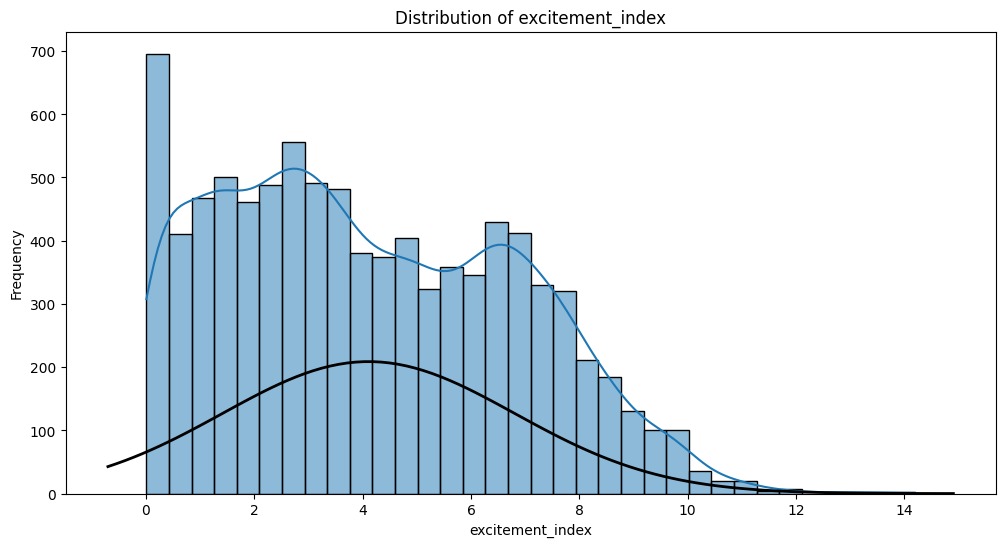

Shapiro-Wilk test - statistic: 0.9632, p-value: 0.0000
Skewness: 0.3586
Kurtosis: -0.7716


/Users/colingaffney/repos/personal-projects/college_football_predictor/venv/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 9054.
  res = hypotest_fun_out(*samples, **kwds)


In [31]:
analyze_distribution(df, 'excitement_index')

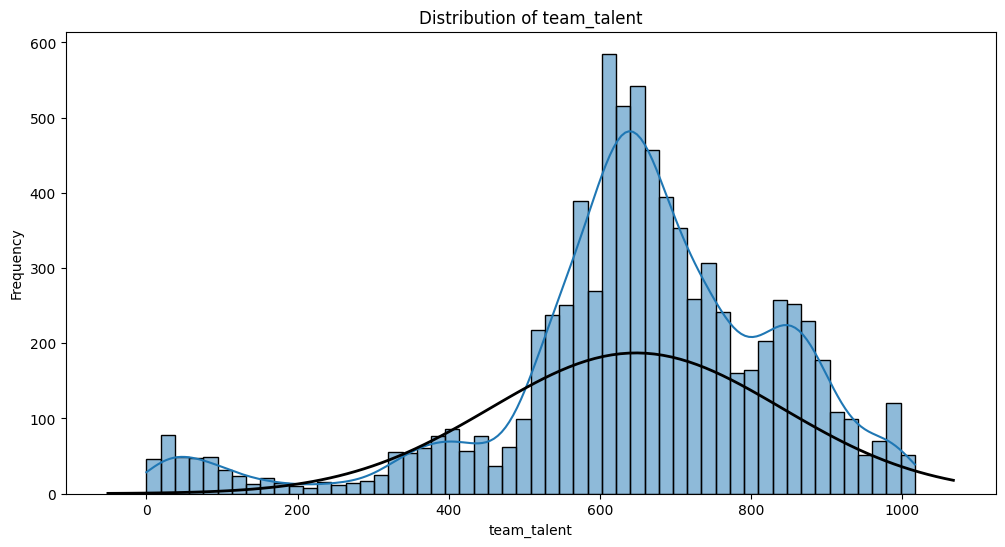

Shapiro-Wilk test - statistic: 0.9227, p-value: 0.0000
Skewness: -1.0655
Kurtosis: 1.9043


/Users/colingaffney/repos/personal-projects/college_football_predictor/venv/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 8096.
  res = hypotest_fun_out(*samples, **kwds)


In [32]:
analyze_distribution(df, 'team_talent')

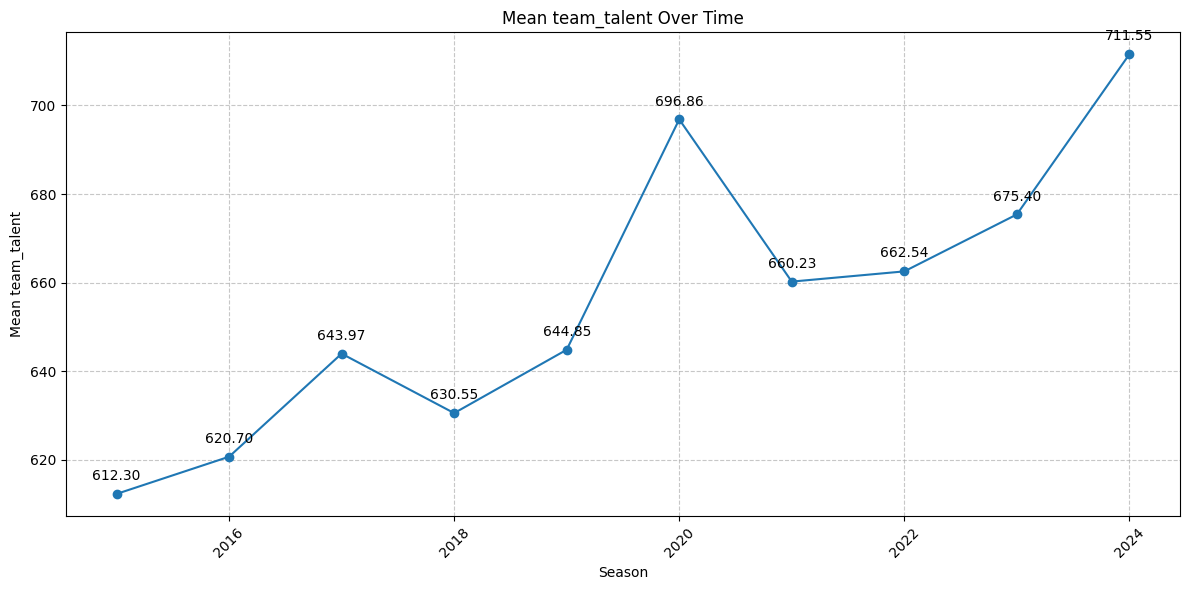

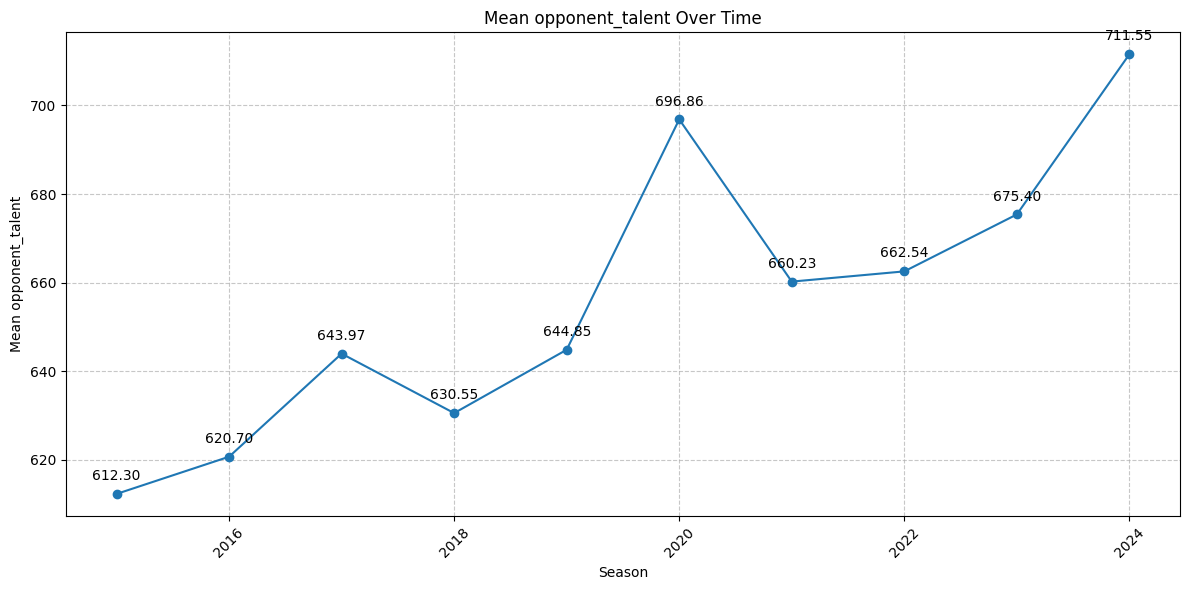

Overall mean team_talent: 647.93
Overall mean opponent_talent: 647.93

Suggestion for handling null values:
Based on the plots and overall means, you could consider the following options:
1. Fill null values with the overall mean of the respective column
2. Use a rolling mean or median from the available data
3. Use a more sophisticated method like forward-filling from the earliest available data for each team
4. If the null values are all before 2015, you might want to consider excluding those years from your analysis


In [36]:
# Plot mean team_talent over time
plot_mean_over_time(df, 'team_talent')

# Plot mean opponent_talent over time
plot_mean_over_time(df, 'opponent_talent')

# Calculate overall mean for team_talent and opponent_talent (excluding null values)
team_talent_mean = df['team_talent'].mean()
opponent_talent_mean = df['opponent_talent'].mean()

print(f"Overall mean team_talent: {team_talent_mean:.2f}")
print(f"Overall mean opponent_talent: {opponent_talent_mean:.2f}")

# Suggestion for handling null values
print("\nSuggestion for handling null values:")
print("Based on the plots and overall means, you could consider the following options:")
print("1. Fill null values with the overall mean of the respective column")
print("2. Use a rolling mean or median from the available data")
print("3. Use a more sophisticated method like forward-filling from the earliest available data for each team")
print("4. If the null values are all before 2015, you might want to consider excluding those years from your analysis")


In [115]:
# Apply the cleaning function
cleaned_df = clean_dataframe(df)

# Check how many rows were removed
print(f"Rows before cleaning: {len(df)}")
print(f"Rows after cleaning: {len(cleaned_df)}")
print(f"Rows removed: {len(df) - len(cleaned_df)}")

# Check for any remaining null values
null_counts = cleaned_df.isnull().sum()
if null_counts.sum() > 0:
    print("\nColumns with remaining null values:")
    print(null_counts[null_counts > 0])
else:
    print("\nNo null values remaining in the dataset.")

Rows before cleaning: 16708
Rows after cleaning: 16430
Rows removed: 278

Columns with remaining null values:
attendance            54
excitement_index    7428
kickReturnYards     4620
kickReturnTDs       4620
kickReturns         4620
tacklesForLoss      9368
defensiveTDs        9368
tackles             9368
sacks               9368
qbHurries           9368
passesDeflected     9368
team_talent         8432
opponent_talent     8432
dtype: int64


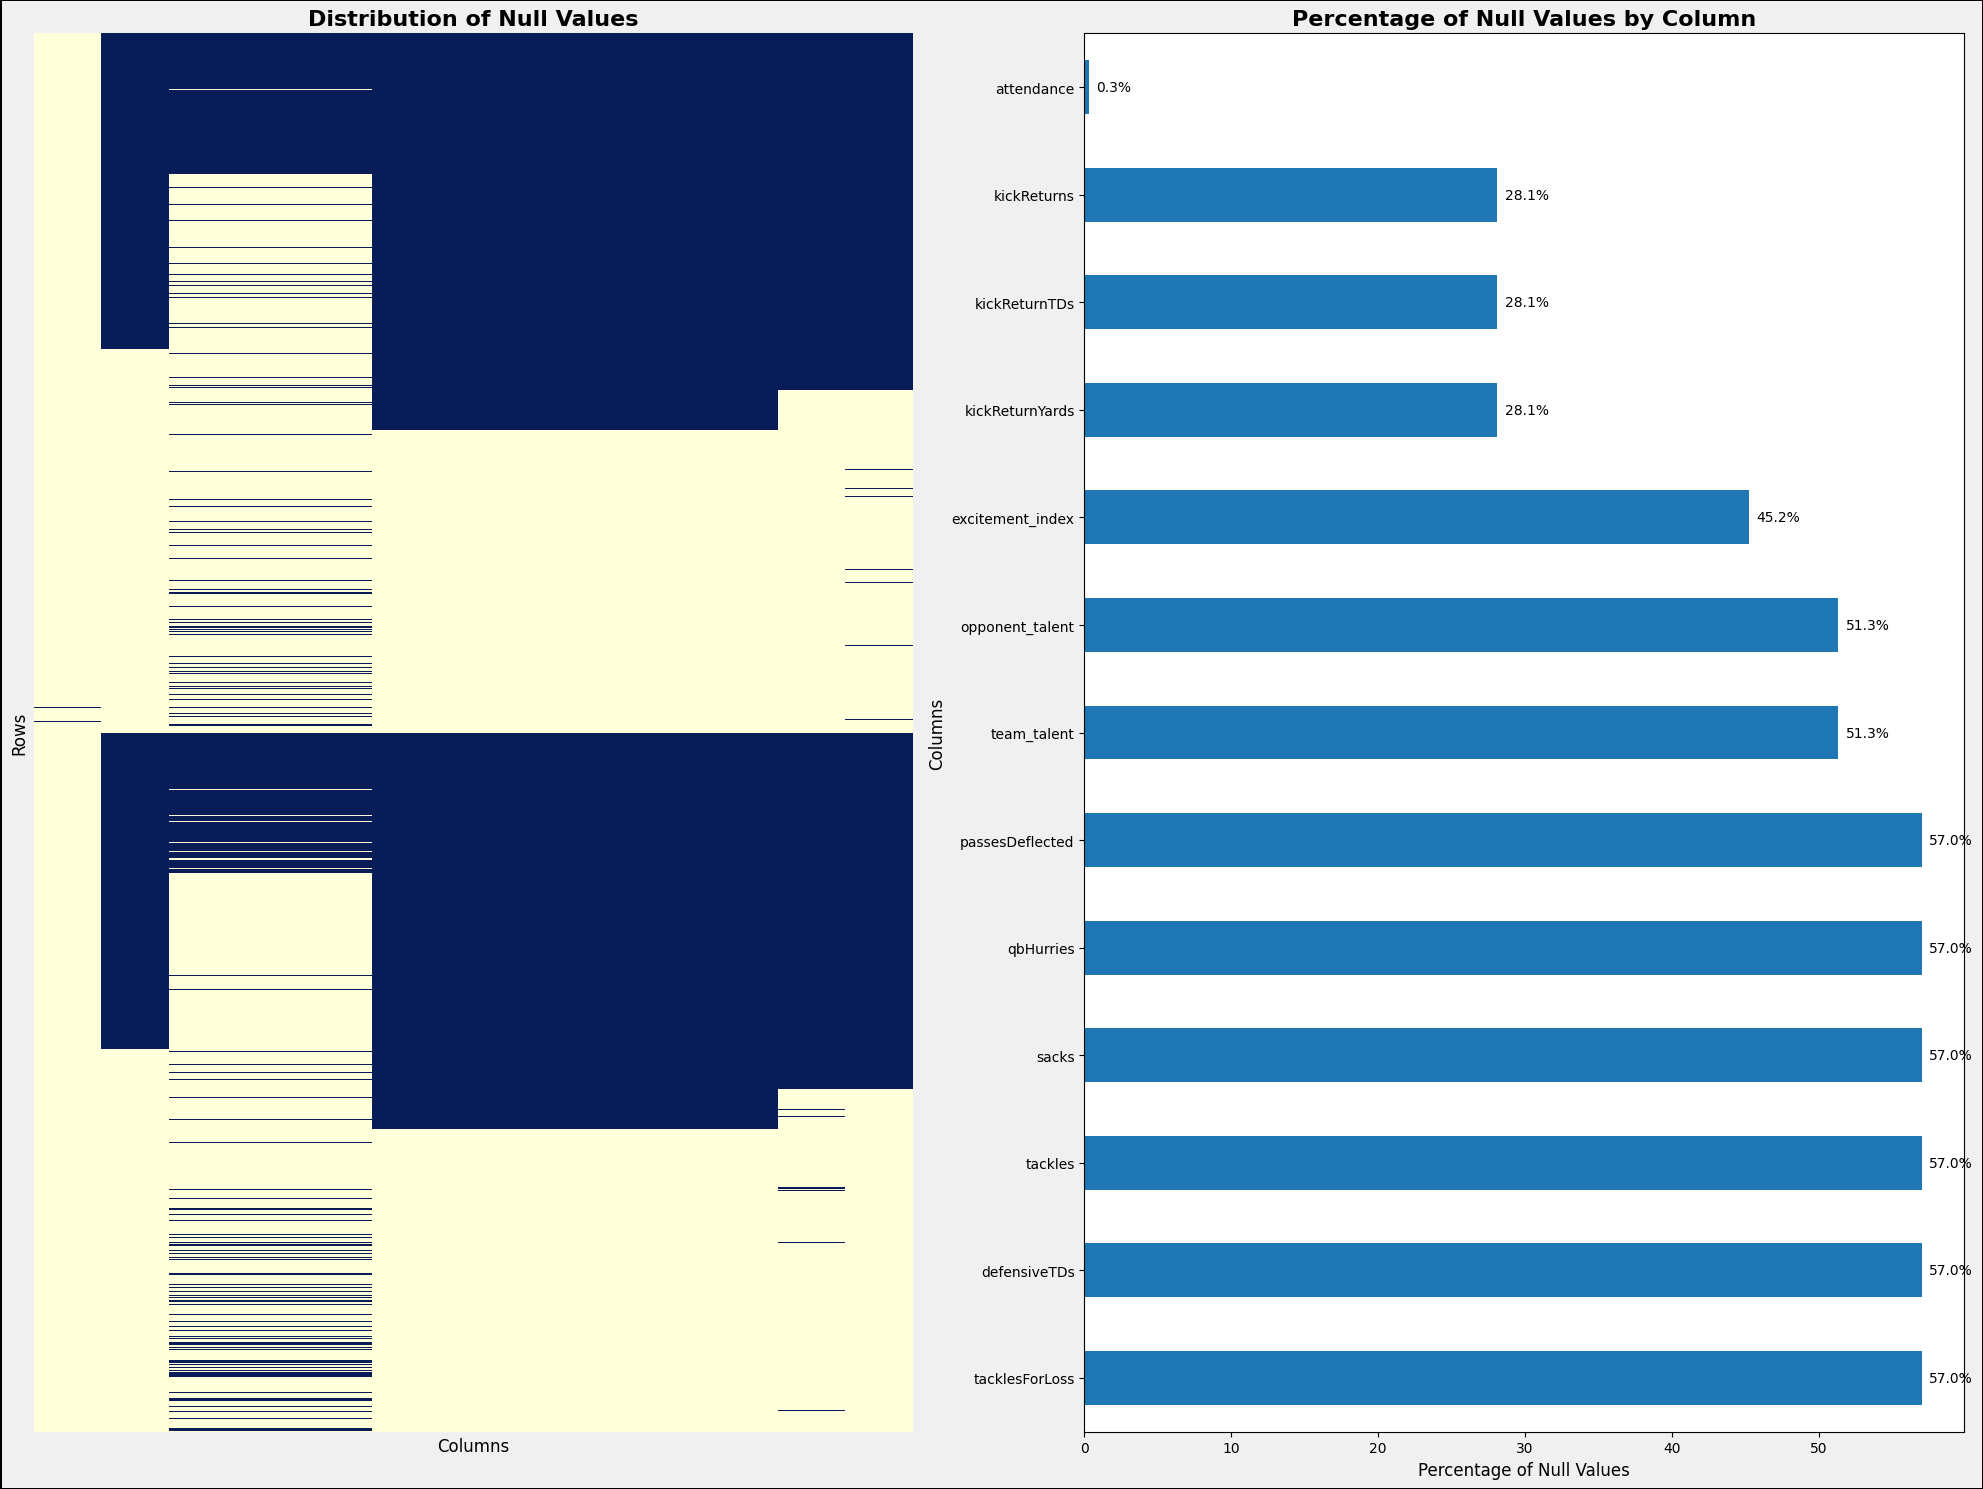

Columns with null values (sorted by percentage, descending):
tacklesForLoss: 9368 null values (57.02%)
defensiveTDs: 9368 null values (57.02%)
tackles: 9368 null values (57.02%)
sacks: 9368 null values (57.02%)
qbHurries: 9368 null values (57.02%)
passesDeflected: 9368 null values (57.02%)
team_talent: 8432 null values (51.32%)
opponent_talent: 8432 null values (51.32%)
excitement_index: 7428 null values (45.21%)
kickReturnYards: 4620 null values (28.12%)
kickReturnTDs: 4620 null values (28.12%)
kickReturns: 4620 null values (28.12%)
attendance: 54 null values (0.33%)


In [116]:
visualize_null_values(cleaned_df)

## Convert Data Types

In [105]:
# Display columns with 'object' data type
object_columns = cleaned_df.select_dtypes(include=['object']).columns
print("Columns with 'object' data type:")
for col in object_columns:
    print(f"- {col}")

Columns with 'object' data type:
- season_type
- start_date
- venue
- team
- team_division
- opponent
- opponent_conference
- opponent_division
- team_name
- team_conference
- home_away
- possessionTime
- totalPenaltiesYards
- completionAttempts
- fourthDownEff
- thirdDownEff
- result


## Matchup and Target Variables

In [113]:
# Create a matchup column with team_id and opponent_id (not sorted)
cleaned_df['matchup'] = cleaned_df.apply(lambda row: (row['team_id'], row['opponent_id']), axis=1)

# Display the first few rows to verify the new column
print(cleaned_df[['team_id', 'opponent_id', 'matchup']].head())

# Display value counts to check the distribution
print("\nTop 10 most common matchups:")
print(cleaned_df['matchup'].value_counts().head(10))

# Ensure 'start_date' column exists and is in the correct format
if 'start_date' not in cleaned_df.columns:
    print("Warning: 'start_date' column is missing. This is required for calculate_team_vs_team_win_rate function.")
else:
    print("'start_date' column exists. Ensure it's in the correct datetime format.")

# Check if 'win' column exists
if 'win' not in cleaned_df.columns:
    print("Warning: 'win' column is missing. This is required for calculate_team_vs_team_win_rate function.")
else:
    print("'win' column exists.")

   team_id  opponent_id      matchup
0     2633          189  (2633, 189)
1       96         2433   (96, 2433)
2        8          242     (8, 242)
3     2390          333  (2390, 333)
4     2390          333  (2390, 333)

Top 10 most common matchups:
matchup
(52, 57)       12
(96, 97)       12
(150, 77)      12
(2579, 228)    12
(97, 96)       12
(57, 52)       12
(59, 61)       12
(228, 2579)    12
(61, 59)       12
(66, 2294)     12
Name: count, dtype: int64
'start_date' column exists. Ensure it's in the correct datetime format.
'win' column exists.


In [114]:
# Create a 'win' column based on the 'result' column
cleaned_df['win'] = cleaned_df['result'].where(cleaned_df['result'] == 'win', 0)
cleaned_df['win'] = cleaned_df['win'].where(cleaned_df['win'] == 0, 1)

# Convert 'win' column to integer type
cleaned_df['win'] = cleaned_df['win'].astype(int)

# Display the first few rows to verify the new column
print(cleaned_df[['result', 'win']].head())

# Display value counts to check the distribution
print("\nValue counts for 'win' column:")
print(cleaned_df['win'].value_counts(normalize=True))

  result  win
0    win    1
1    win    1
2    win    1
3   loss    0
4   loss    0

Value counts for 'win' column:
win
1    0.5
0    0.5
Name: proportion, dtype: float64


## Save to Parquet

In [115]:
# Save cleaned_df to root/data as clean_team_data.parquet

#! save one 2015+, one without talent

# Define the path for the data directory
data_dir = os.path.join(project_root, 'data')

# Save the cleaned DataFrame as a Parquet file
parquet_path = os.path.join(data_dir, 'clean_team_data.parquet')
cleaned_df.to_parquet(parquet_path, index=False)

print(f"Cleaned data saved to: {parquet_path}")

Cleaned data saved to: /Users/colingaffney/repos/personal-projects/college_football_predictor/data/clean_team_data.parquet


In [2]:
# Assuming you're in the same notebook or have access to the project_root variable
data_dir = os.path.join(project_root, 'data')
parquet_path = os.path.join(data_dir, 'clean_team_data.parquet')

# Load the cleaned data
cleaned_df = pd.read_parquet(parquet_path)

# Verify the data was loaded correctly
print(f"Loaded DataFrame shape: {cleaned_df.shape}")
print(f"\nFirst few rows:\n{cleaned_df.head()}")

Loaded DataFrame shape: (3346, 122)

First few rows:
          id  season  week season_type                start_date  \
0  401281952    2021     1     regular  2021-09-03T00:00:00.000Z   
1  401281947    2021     1     regular  2021-09-04T16:00:00.000Z   
2  401281943    2021     1     regular  2021-09-04T18:00:00.000Z   
3  401281942    2021     1     regular  2021-09-04T19:30:00.000Z   
4  401281942    2021     1     regular  2021-09-04T19:30:00.000Z   

   neutral_site  conference_game  attendance  venue_id  \
0         False            False     84314.0      3853   
1         False            False     47693.0      3683   
2         False            False     64065.0      3887   
3          True            False     71829.0      5348   
4          True            False     71829.0      5348   

                                               venue  ...  \
0                                    Neyland Stadium  ...   
1                               Commonwealth Stadium  ...   
2  Don

## Team Pairs

In [9]:
team_pairs_file = generate_and_save_team_pairs(cleaned_df, project_root)
print(f"Team pairs saved to: {team_pairs_file}")


Team pairs saved to: /Users/colingaffney/repos/personal-projects/college_football_predictor/src/utils/team_pairs.py


## Check for Duplicates